In [3]:
import matplotlib
matplotlib.use('Agg')

# Handle table-like data and matrices
import numpy as np
import pandas as pd

# Helpers
import sys
sys.path.insert(0,'../../')
from utils import data_path,results_path,grid_search,estimator_result,cross_validate,evaluate_param
from scipy.sparse import csr_matrix,save_npz,load_npz
from sklearn.model_selection import cross_val_score,LeaveOneOut,StratifiedKFold
from sklearn.metrics import accuracy_score,roc_auc_score,roc_curve
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
import pickle

# Feature selection
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFECV,VarianceThreshold

# Algorithm
from sklearn.linear_model import LogisticRegression,LogisticRegressionCV
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

## Load data

In [4]:
train_X = load_npz(data_path + 'version_1/'+ 'train_bin.npz')
test_X = load_npz(data_path + 'version_1/'+ 'test_bin.npz')

train_y = pd.read_csv(data_path + 'train_Y.csv')['CMV_status']
test_y = pd.read_csv(data_path + 'test_Y.csv')['CMV_status']

**Select top 70 features**

In [5]:
with open(data_path + 'sorted_TCRs_ind.pkl', 'rb') as f:
    TCRs_ind = pickle.load(f)

p = 70
ind = TCRs_ind[:p]
train_X_sub = train_X[:,ind].toarray()
test_X_sub = test_X[:,ind].toarray()

## Define classifier

In [6]:
rf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                max_depth=31, max_features='auto', max_leaf_nodes=None,
                min_impurity_decrease=0.0, min_impurity_split=None,
                min_samples_leaf=1, min_samples_split=5,
                min_weight_fraction_leaf=0.0, n_estimators=180, n_jobs=1,
                oob_score=True, random_state=0, verbose=0, warm_start=False)

## Feature selection

### Testing each feature

ValueError: x and y must have same first dimension, but have shapes (70,) and (61,)

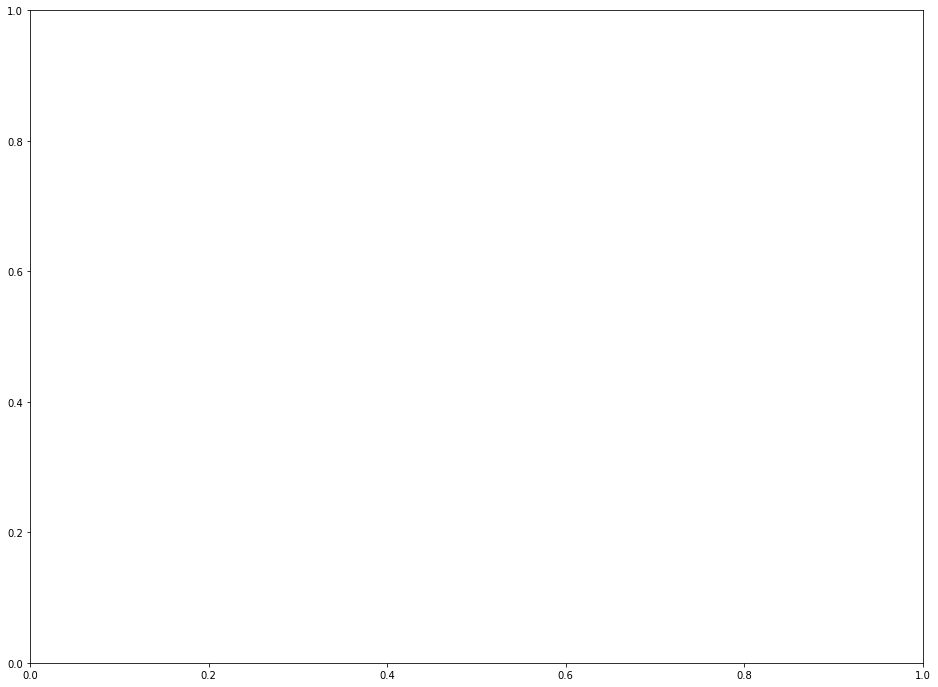

In [15]:
cv_auroc = []
cv_acc = []
test_auroc = []
test_acc = []

ind_list = ind.tolist()[:61]

for i in ind_list:
    sub_ind = ind_list.copy()
    sub_ind.remove(i)
    train_x_sub = train_X[:,sub_ind].toarray()
    test_x_sub = test_X[:,sub_ind].toarray()
    cv_results = cross_validate(rf,train_x_sub,train_y,scoring=('accuracy', 'roc_auc'),cv=StratifiedKFold(10,random_state=0))
    cv_acc.append(np.mean(cv_results['test_accuracy']))
    cv_auroc.append(np.mean(cv_results['test_roc_auc']))

    # fit training set
    rf.fit(X=train_x_sub, y=train_y)

    # predict test_Y
    predict_test = rf.predict(test_x_sub)
    test_acc.append(accuracy_score(test_y, predict_test))

    # AUROC of testing set
    predict_test_prob = rf.predict_proba(test_x_sub)
    pos_prob_test = predict_test_prob[:, 1]
    test_auroc.append(roc_auc_score(test_y, pos_prob_test))
    
    
fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(111)
line1 = ax.plot(range(1,len(ind)+1,1),cv_auroc,label='CV_AUROC',marker='o')
line2 = ax.plot(range(1,len(ind)+1,1),cv_acc,label='CV_Accuracy',marker='o')
line3 = ax.plot(range(1,len(ind)+1,1),test_auroc,label='Test_AUROC',marker='o')
line4 = ax.plot(range(1,len(ind)+1,1),test_acc,label='Test_Accuracy',marker='o')

ax.set_ylabel('Scores')
ax.set_xlabel('Removed feature')
ax.set_xticks(range(0,len(ind)+1,1))
ax.set_yticks(np.arange(0.5,1,0.1))
ax.legend(loc='best', bbox_to_anchor=(1,1))

print('Best(cv_auroc)')
index_cv_auc = cv_auroc.index(max(cv_auroc))
print('Max CV AUROC:',cv_auroc[index_cv_auc],'with accuracy:',cv_acc[index_cv_auc])
print('index of Removed feature',index_cv_auc)

print('Best(cv_acc)')
index_cv_acc = cv_acc.index(max(cv_acc))
print('Max CV ACC:',cv_auroc[index_cv_acc],'with accuracy:',cv_acc[index_cv_acc])
print('index of Removed feature',index_cv_acc)

print('Best(test_auroc)')
index_test_auc = test_auroc.index(max(test_auroc))
print('Max test AUROC:',test_auroc[index_test_auc],'with accuracy:',test_acc[index_test_auc])
print('index of Removed feature',index_test_auc)

print('Best(test_acc)')
index_test_acc = test_acc.index(max(test_acc))
print('Max test AUROC:',test_auroc[index_test_acc],'with accuracy:',test_acc[index_test_acc])
print('index of Removed feature',index_test_acc)

plt.show()

In [14]:
ind_list = ind.tolist()[:62]
sub_ind = ind_list.copy()
# sub_ind.remove(sub_ind[4])
train_x_sub = train_X[:,sub_ind].toarray()
test_x_sub = test_X[:,sub_ind].toarray()
cv_results = cross_validate(rf,train_x_sub,train_y,scoring=('accuracy', 'roc_auc'),cv=StratifiedKFold(10,random_state=0))
print('CV acc:',np.mean(cv_results['test_accuracy']))
print('CV auroc:',np.mean(cv_results['test_roc_auc']))

rf.fit(X=train_x_sub, y=train_y)

# predict test_Y
predict_test = rf.predict(test_x_sub)
print('Test acc:',accuracy_score(test_y, predict_test))

# AUROC of testing set
predict_test_prob = rf.predict_proba(test_x_sub)
pos_prob_test = predict_test_prob[:, 1]
print('Test auroc:',roc_auc_score(test_y, pos_prob_test))

CV acc: 0.8815098443223442
CV auroc: 0.942757447806709
Test acc: 0.9
Test auroc: 0.9249786871270247


In [8]:
ind_gt_auroc = np.argwhere(np.array(test_auroc) > 0.939).flatten().tolist()
ind_gt_acc = np.argwhere(np.array(test_acc) > 0.892).flatten().tolist()
ind_gt = np.intersect1d(ind_gt_auroc,ind_gt_acc)
for i_cv_auroc, i_cv_acc, i_test_auroc, i_test_acc in zip(np.array(cv_auroc)[ind_gt],np.array(cv_acc)[ind_gt],np.array(test_auroc)[ind_gt],np.array(test_acc)[ind_gt]):
    print('cv_auroc: %.3f, cv_acc: %.3f, test_auroc: %.3f, test_acc: %.3f'%(i_cv_auroc,i_cv_acc,i_test_auroc,i_test_acc))

cv_auroc: 0.942, cv_acc: 0.888, test_auroc: 0.940, test_acc: 0.925
cv_auroc: 0.944, cv_acc: 0.891, test_auroc: 0.940, test_acc: 0.925
cv_auroc: 0.942, cv_acc: 0.899, test_auroc: 0.940, test_acc: 0.908
cv_auroc: 0.946, cv_acc: 0.897, test_auroc: 0.940, test_acc: 0.917


In [10]:
ind_gt_auroc = np.argwhere(np.array(test_auroc) > 0.951).flatten().tolist()
ind_gt_acc = np.argwhere(np.array(test_acc) > 0.933).flatten().tolist()
ind_gt = np.intersect1d(ind_gt_auroc,ind_gt_acc)
if len(ind_gt)==0:
    print('No feature matches the requirement')
else:
    for i_cv_auroc, i_cv_acc, i_test_auroc, i_test_acc in zip(np.array(cv_auroc)[ind_gt],np.array(cv_acc)[ind_gt],np.array(test_auroc)[ind_gt],np.array(test_acc)[ind_gt]):
        print('cv_auroc: %.3f, cv_acc: %.3f, test_auroc: %.3f, test_acc: %.3f'%(i_cv_auroc,i_cv_acc,i_test_auroc,i_test_acc))

No feature matches the requirement


## Correlation

In [5]:
# Get TCRs
store = pd.HDFStore(data_path+'version_1/'+'data.h5')
print(store.keys())
train = store['train']
store.close()

['/test', '/train']


In [6]:
train.drop(['sample_name','CMV_status'],axis=1,inplace=True)
TCRs = train.columns.values

In [7]:
df = pd.DataFrame(train_X_sub,columns=TCRs[ind])

In [8]:
multiindex=pd.MultiIndex.from_tuples(TCRs[ind].tolist())
df2 = pd.DataFrame(train_X_sub,columns=multiindex)
df2.head()

,TCRBV09,TCRBV19,TCRBV05,TCRBV07,TCRBV28,TCRBV24,TCRBV05,TCRBV07,TCRBV09,TCRBV04,...,TCRBV05,TCRBV02,TCRBV11,TCRBV20,TCRBV10,TCRBV05,TCRBV11,TCRBV05,TCRBV07,TCRBV28
,TCRBV09-01,TCRBV19-01,TCRBV05-01,TCRBV07-02,TCRBV28-01,unresolved,TCRBV05-06,TCRBV07-06,TCRBV09-01,TCRBV04-03,...,TCRBV05-06,TCRBV02-01,TCRBV11-01,unresolved,TCRBV10-02,TCRBV05-06,TCRBV11-02,TCRBV05-05,TCRBV07-08,TCRBV28-01
,null,null,01,01,01,null,01,01,null,01,...,01,01,01,null,01,01,02,01,01,01
,CASSGQGAYEQYF,CASSIGPLEHNEQFF,CASSPDRVGQETQYF,CASSLEAEYEQYF,CASSIEGNQPQHF,CATSDGDEQFF,CASSLVAGGRETQYF,CASSRGRQETQYF,CASSAGQGVTYEQYF,CASSPQRNTEAFF,...,CASSSGQVYGYTF,CASSEEGIQPQHF,CASSFPGGETQYF,CSALGHSNQPQHF,CASSEGARQPQHF,CASSLETYGYTF,CASSSGQVQETQYF,CASSLLWDQPQHF,CASSLVGDGYTF,CASSSRGTGELFF
,TCRBJ02,TCRBJ02,TCRBJ02,TCRBJ02,TCRBJ01,TCRBJ02,TCRBJ02,TCRBJ02,TCRBJ02,TCRBJ01,...,TCRBJ01,TCRBJ01,TCRBJ02,TCRBJ01,TCRBJ01,TCRBJ01,TCRBJ02,TCRBJ01,TCRBJ01,TCRBJ02
,TCRBJ02-07,TCRBJ02-01,TCRBJ02-05,TCRBJ02-07,TCRBJ01-05,TCRBJ02-01,TCRBJ02-05,TCRBJ02-05,TCRBJ02-07,TCRBJ01-01,...,TCRBJ01-02,TCRBJ01-05,TCRBJ02-05,TCRBJ01-05,TCRBJ01-05,TCRBJ01-02,TCRBJ02-05,TCRBJ01-05,TCRBJ01-02,TCRBJ02-02
,01,01,01,01,01,01,01,01,01,01,...,01,01,01,01,01,01,01,01,01,01
0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.000004,0.0,0.0,0.000007,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0


In [20]:
df_test = pd.DataFrame(test_X_sub,columns=TCRs[ind])
multiindex=pd.MultiIndex.from_tuples(TCRs[ind].tolist())
df2_test = pd.DataFrame(test_X_sub,columns=multiindex)

### Pearson

In [8]:
# f,ax = plt.subplots(figsize=(20, 20))
corr = df.corr()
# mask = np.zeros_like(corr, dtype=np.bool)
# mask[np.triu_indices_from(mask)] = True
# sns.heatmap(corr, annot=True, linewidths=.5, mask=mask,fmt= '.1f',ax=ax)
# plt.show()

In [47]:
corr_ind_gt = np.argwhere(abs(corr.values) >= 0.7)

In [48]:
temp = []
for i in range(corr_ind_gt.shape[0]):
    if corr_ind_gt[i][0] == corr_ind_gt[i][1]:
        continue
    else:
        if corr_ind_gt[i][0]<corr_ind_gt[i][1]:
            temp.append(corr_ind_gt[i])
print(temp)

[array([22, 51]), array([34, 51]), array([42, 48]), array([42, 88]), array([48, 88]), array([51, 57]), array([51, 83]), array([ 51, 102]), array([57, 83])]


**Correlation>=0.7:[ 22,  51],[ 34,  51],[ 42,  48],[ 42,  88],[ 48,  88],[ 51,  57],[ 51,  83],[ 51, 102],[ 57,  83]**

In [22]:
for i in range(len(temp)):
    print(temp[i][0],temp[i][1],': ',corr.values[temp[i][0]][temp[i][1]])

22 51 :  0.7070200642637918
34 51 :  0.7401674525085351
42 48 :  0.8371214682226769
42 88 :  0.8665376535849382
48 88 :  0.8041029220943036
51 57 :  0.7515509334257473
51 83 :  0.7699200089402499
51 102 :  0.702317679194976
57 83 :  0.7077904282634359


### Spearman

In [43]:
corr2 = df.corr(method= 'spearman')

In [56]:
corr_ind_gt2 = np.argwhere(abs(corr.values) >= 0.5)

In [57]:
temp2 = []
for i in range(corr_ind_gt2.shape[0]):
    if corr_ind_gt2[i][0] == corr_ind_gt2[i][1]:
        continue
    else:
        if corr_ind_gt2[i][0]<corr_ind_gt2[i][1]:
            temp.append(corr_ind_gt2[i])
print(temp2)

[]


**There are no two features spearman corelated**

###  Mutual Information

In [60]:
from sklearn.feature_selection import mutual_info_classif
mi = mutual_info_classif(train_X_sub,train_y)

### Distance correlation

In [96]:
from scipy.spatial.distance import pdist,correlation,squareform,euclidean

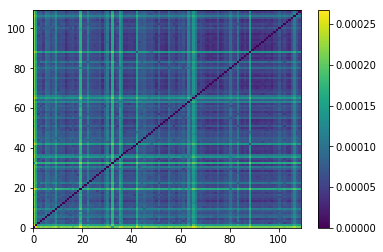

In [84]:
dist_mat = squareform(pdist(train_X_sub.T))

N = train_X_sub.shape[1]
plt.pcolormesh(dist_mat)
plt.colorbar()
# plt.xlim([0,N])
# plt.ylim([0,N])
plt.show()

In [ ]:
# pd.DataFrame(squareform(pdist(df.T)), columns=df.columns.values, index=df.columns.values)